In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn import externals
from io import StringIO
import pydotplus
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz

import warnings
warnings.filterwarnings('ignore')

### 1. Business Problem
### Use decision trees to prepare a model on fraud data treating those who have taxable_income <= 30000 as "Risky" and others are "Good"

### 2. Data Description :

### Undergrad : person is under graduated or not
### Marital.Status : marital status of a person
### Taxable.Income : Taxable income is the amount of how much tax an individual owes to the government 
### Work Experience : Work experience of an individual person
### Urban : Whether that person belongs to urban area or not

In [4]:
fraud_check = pd.read_csv('Fraud_check.csv')
fraud_check

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO
...,...,...,...,...,...,...
595,YES,Divorced,76340,39492,7,YES
596,YES,Divorced,69967,55369,2,YES
597,NO,Divorced,47334,154058,0,YES
598,YES,Married,98592,180083,17,NO


In [5]:
fraud_check1 = fraud_check.copy()
fraud_check1

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO
...,...,...,...,...,...,...
595,YES,Divorced,76340,39492,7,YES
596,YES,Divorced,69967,55369,2,YES
597,NO,Divorced,47334,154058,0,YES
598,YES,Married,98592,180083,17,NO


In [6]:
fraud_check1.describe().T

,count,mean,std,min,25%,50%,75%,max
Taxable.Income,600.0,55208.375000,26204.827597,10003.0,32871.50,55074.5,78611.75,99619.0
City.Population,600.0,108747.368333,49850.075134,25779.0,66966.75,106493.5,150114.25,199778.0
Work.Experience,600.0,15.558333,8.842147,0.0,8.00,15.0,24.00,30.0


In [7]:
fraud_check1.isnull().sum()

Undergrad          0
Marital.Status     0
Taxable.Income     0
City.Population    0
Work.Experience    0
Urban              0
dtype: int64

In [8]:
fraud_check1.dtypes

Undergrad          object
Marital.Status     object
Taxable.Income      int64
City.Population     int64
Work.Experience     int64
Urban              object
dtype: object

### Outlier Check

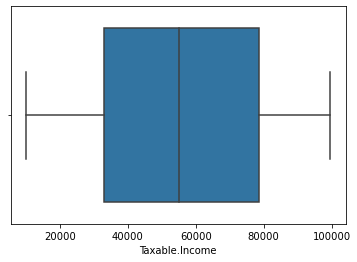

In [11]:
ax = sns.boxplot(fraud_check1['Taxable.Income']) #There are no outliers in the data

Skew: 0.030014788906377175
Kurtosis: -1.1997824607083138


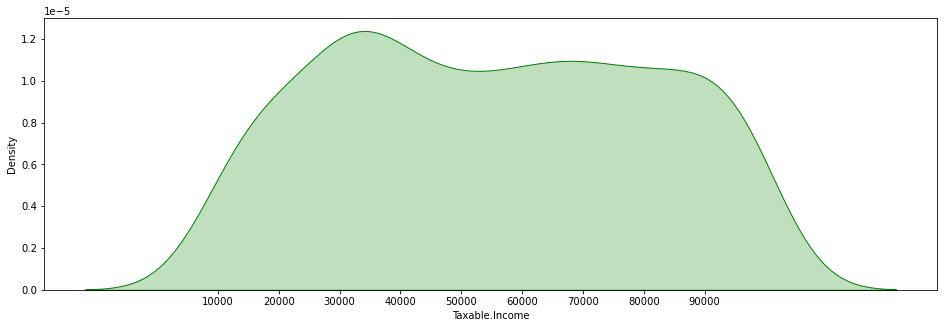

In [12]:
plt.rcParams["figure.figsize"] = 9,5
plt.figure(figsize=(16,5))
print("Skew: {}".format(fraud_check1['Taxable.Income'].skew()))
print("Kurtosis: {}".format(fraud_check1['Taxable.Income'].kurtosis()))
ax = sns.kdeplot(fraud_check1['Taxable.Income'],shade=True,color='g')
plt.xticks([i for i in range(10000,100000,10000)])
plt.show()

### The data is Skwed on the right

### The data has negative Kurtosis

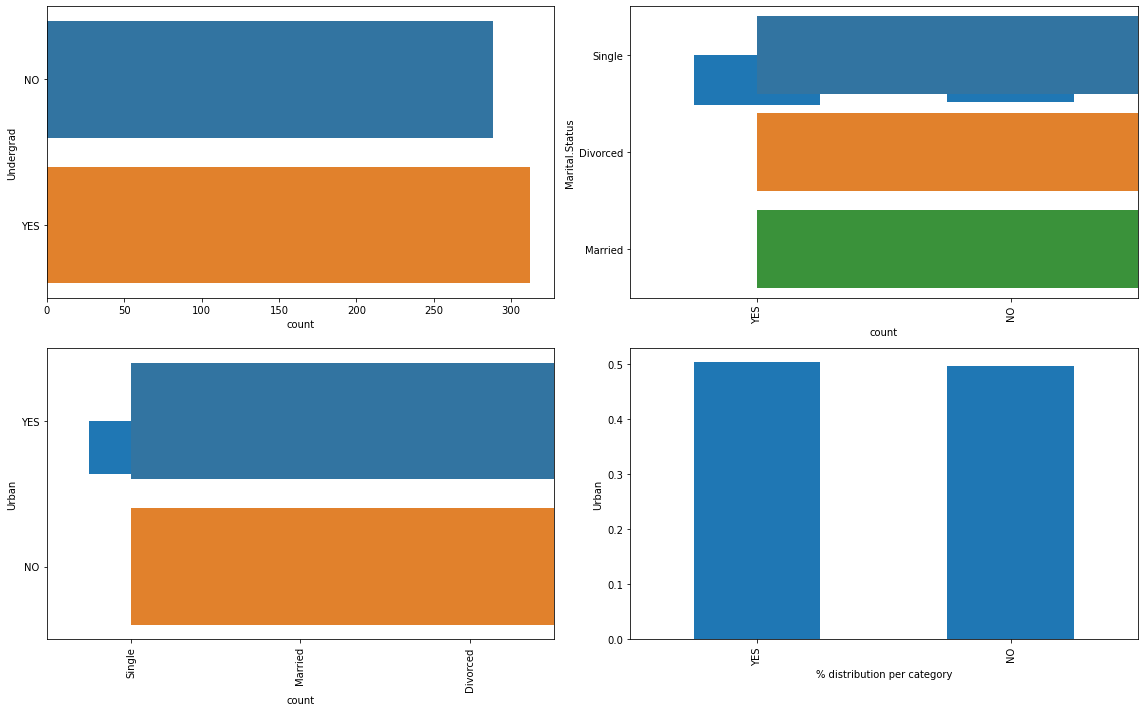

In [13]:
obj_colum = fraud_check1.select_dtypes(include='object').columns.tolist()

plt.figure(figsize=(16,10))
for i,col in enumerate(obj_colum,1):
    plt.subplot(2,2,i)
    sns.countplot(data=fraud_check1,y=col)
    plt.subplot(2,2,i+1)
    fraud_check1[col].value_counts(normalize=True).plot.bar()
    plt.ylabel(col)
    plt.xlabel('% distribution per category')
plt.tight_layout()
plt.show()

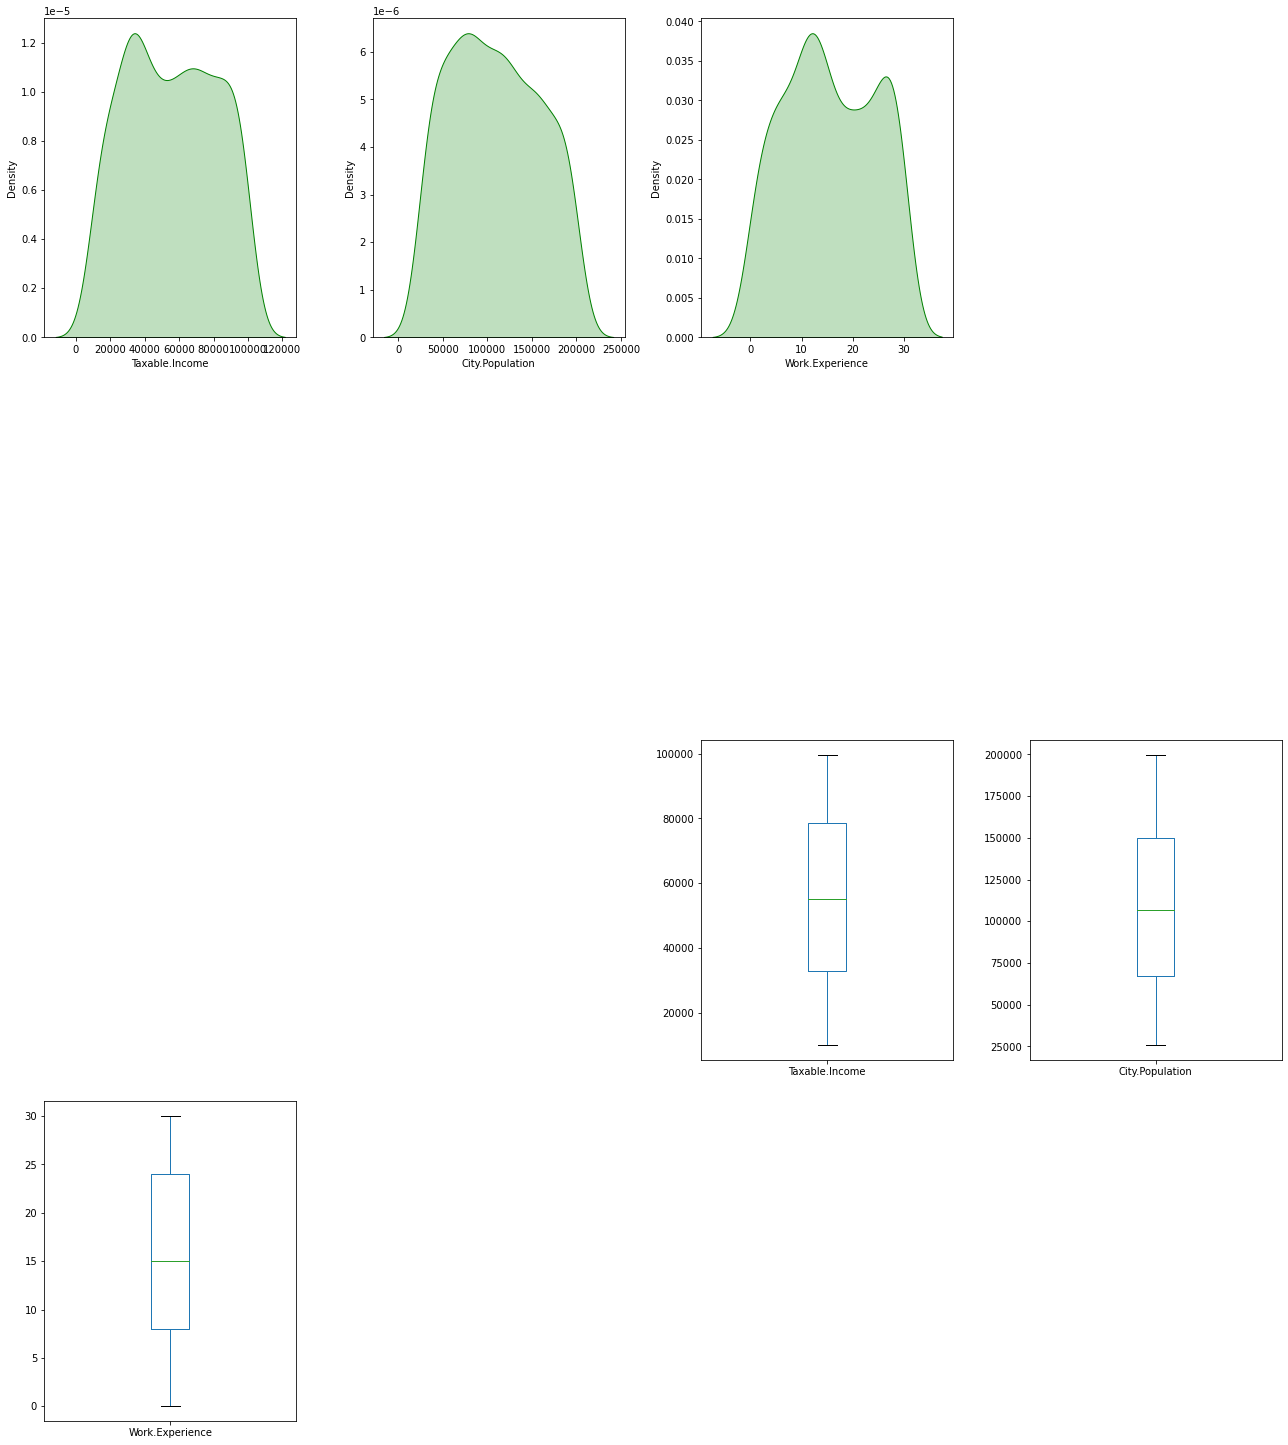

,Taxable.Income,City.Population,Work.Experience
skewness,0.030015,0.125009,0.018529
kurtosis,-1.199782,-1.120154,-1.167524


In [14]:
num_columns = fraud_check1.select_dtypes(exclude='object').columns.tolist()
plt.figure(figsize=(18,40))
for i,col in enumerate(num_columns,1):
    plt.subplot(8,4,i)
    sns.kdeplot(fraud_check[col],color='g',shade=True)
    plt.subplot(8,4,i+10)
    fraud_check[col].plot.box()
plt.tight_layout() 
plt.show()
num_data = fraud_check[num_columns]
pd.DataFrame(data=[num_data.skew(),num_data.kurtosis()],index=['skewness','kurtosis'])

In [15]:
fraud_check1 = pd.get_dummies(fraud_check1, columns = ['Undergrad','Marital.Status','Urban'])

In [16]:
corr = fraud_check1.corr()

In [17]:
corr = fraud_check1.corr()

<AxesSubplot:>

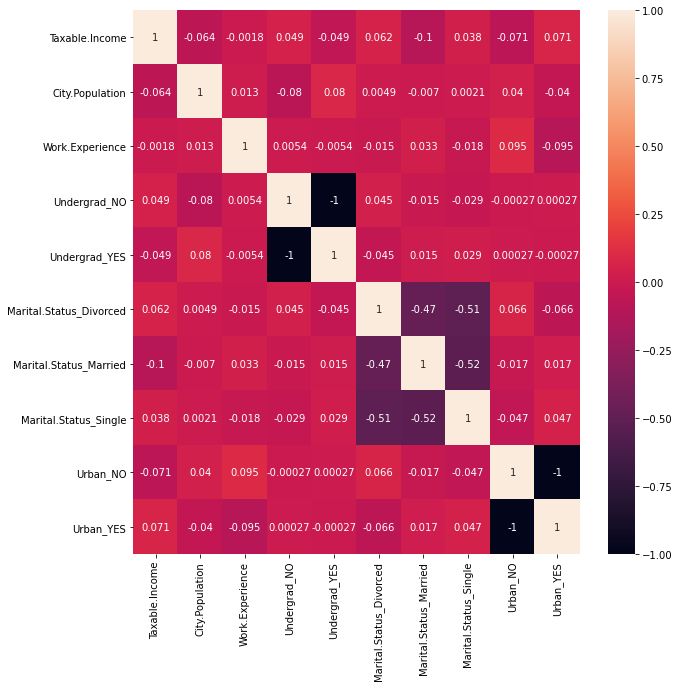

In [18]:
plt.figure(figsize=(10,10))
sns.heatmap(corr,annot=True)

### 3 - Decision Tree

### Since the target variable is continious, we create a class of taxable_income <= 30000 as "Risky" and others are "Good"¶

In [19]:
fraud_check1['Taxable.Income']=pd.cut(fraud_check1['Taxable.Income'],bins=[0,30000,100000],labels=['risky','good'])

In [20]:
list(fraud_check1.columns)

['Taxable.Income',
 'City.Population',
 'Work.Experience',
 'Undergrad_NO',
 'Undergrad_YES',
 'Marital.Status_Divorced',
 'Marital.Status_Married',
 'Marital.Status_Single',
 'Urban_NO',
 'Urban_YES']

In [21]:
X = fraud_check1.iloc[:,1:10]
y = fraud_check1.iloc[:,0]

In [33]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.20)

In [34]:
y_train.value_counts()

good     381
risky     99
Name: Taxable.Income, dtype: int64

In [35]:
model = DT(criterion='entropy') 
model.fit(x_train,y_train)

DecisionTreeClassifier(criterion='entropy')

In [36]:
pred_train = model.predict(x_train)
print('Accuracy Score :',accuracy_score(y_train,pred_train))
print('Confusion Matrix:\n',confusion_matrix(y_train,pred_train))

Accuracy Score : 1.0
Confusion Matrix:
 [[381   0]
 [  0  99]]


In [38]:
pred_test = model.predict(x_test)
print('Accuracy Score :',accuracy_score(y_test,pred_test))
print('Confusion Matrix:\n',confusion_matrix(y_test,pred_test))

Accuracy Score : 0.625
Confusion Matrix:
 [[70 25]
 [20  5]]


In [39]:
df_t=pd.DataFrame({'Actual':y_test, 'Predicted':pred_test})
df_t

,Actual,Predicted
358,good,good
141,good,risky
254,good,good
260,good,good
449,good,good
...,...,...
564,good,good
195,good,good
365,good,good
115,good,good


In [41]:
cols = list(fraud_check1.columns)

In [42]:
predictors = cols[1:10]
target = cols[0]

In [43]:
dot_data = StringIO()

In [45]:
export_graphviz(model, out_file = dot_data ,filled = True,rounded =True,feature_names = predictors,class_names = target, impurity = False)

In [46]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

In [47]:
graph.write_png('fraud_full.png')

AttributeError: 'list' object has no attribute 'write_png'

### 4 - Conclusion

### Since the accuracy of the Training set is 100% we test the accurancy on the test data which is 62%
### As seen in the confusion matrix of Test data 75 instances are presdected correctly and 45 instances are not

In [48]:
model.feature_importances_

array([0.59668412, 0.18028922, 0.02645293, 0.03047198, 0.04897977,
       0.04430516, 0.02615832, 0.02017922, 0.02647927])

In [50]:
feature_impt = pd.DataFrame({'feature': list(x_train.columns),
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)
feature_impt

,feature,importance
0,City.Population,0.596684
1,Work.Experience,0.180289
4,Marital.Status_Divorced,0.048980
5,Marital.Status_Married,0.044305
3,Undergrad_YES,0.030472
8,Urban_YES,0.026479
2,Undergrad_NO,0.026453
6,Marital.Status_Single,0.026158
7,Urban_NO,0.020179
